<!--HEADER-->
*[Guia de aulas da disciplina de Modelagem Matemática](https://github.com/rmsrosa/modelagem_matematica) do [IM-UFRJ](https://www.im.ufrj.br).*

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/13.00-Aula13.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/13.00-Aula13.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/13.00-Aula13.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Projeto 3: Controle de epidemia via vacinação](12.05-Projeto3.ipynb) | [Página Inicial](00-Sumario.ipynb) 

---


# Aula 13: Epidemiologia: o modelo SIR em rede

## Objetivos:

- Modelos epidemiológicos em rede

## Importando bibliotecas e definindo funções a serem usadas abaixo

In [1]:
from os import path

import numpy as np
from scipy.integrate import odeint

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import io, base64
from IPython.display import Image, HTML

def path_files_epidemiologia(filename):
    return path.join('..', 'dados', 'epidemiologia', filename)

## Modelos em rede

Modelos em rede englobam, na verdade, diferentes tipos de modelagem. 

Uma **rede** é composta de **vértices** e **arestas**. 

Dependendo da modelagem, cada **vértice** pode representar **grupos de indivíduos**, **sítios** ou até mesmo **um único indivíduo**. 

No caso de **grupos de indivíduos**, as **arestas** representam as **interações entre cada grupo** nos extremos de cada aresta. A aresta pode ser **direcionada** (e.g. transfusão de sangue) **ou não**. E podem mudar ao longo do tempo.

No caso de cada vértice representar um **sítio**, as **arestas** representam os **deslocamentos** de parte da população **de um sítio para o outro**. E não costumam mudar ao longo do tempo.

Em ambos os casos, cada **vértice** contém um certo número de **indivíduos suscetíveis**, outro de **infectados**, outro de **recuperados**, e assim por diante, dependendo dos estágios considerados para a epidemia considerada.

No caso de cada **vértice** representar **um único indivíduo**, então o **vértice** está em **um único estado**, seja suscetível, infectado ou recuperado. E os vértices mudam constantemente, representando as mudanças de interações.

### Rede com vértices de sítios

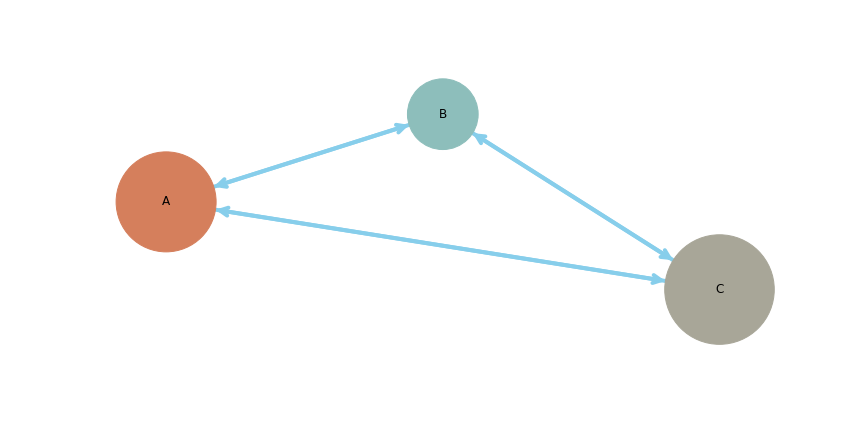

In [2]:
Image(path_files_epidemiologia('rede_sitios.png'))

### Rede com vértices de indivíduos

Animação obtida do curso [Network Modeling for Epidemics](https://statnet.github.io/nme/) de Universidade de Washington.

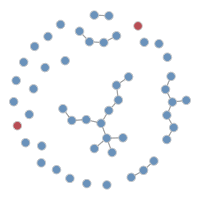

In [3]:
Image(path_files_epidemiologia('network_dynamics.gif'))

## Modelo SIR em rede de sítios

### Representação do sistema

Nesse caso, consideramos 

- $m$ **sítios**.

- Em cada sítio, uma **população total** $N_i$, com um número $S_i$ de **suscetíveis**, $I_i$ de **infectados** e $R_i$ de **recuperados**, $i=1, \ldots, m$.

- Sem vitalidade, de forma que $S_i + I_i + R_i = N_i$ é constante, para cada $i=1, \ldots, m$.

### Dinâmica

- Denominamos por **um ciclo** cada unidade de tempo, digamos um dia.

- O **ciclo** possui uma fase **ativa**, onde a infeção pode ocorrer, e uma fase **inativa**, onde não há transmissão da infecção.

- Na fase **ativa** de cada ciclo, uma **fração** $\alpha_{ij}$ da população $N_i$ migra **do sítio $i$ para o sítio $j$**, voltando ao sítio $i$ na fase **inativa**.

- Naturalmente, $0\leq \alpha_{ij} \leq 1$, para cada $i,j=1, \ldots, m$, e $\sum_{j=1}^m\alpha_{ij} = 1$, para cada $i=1,\ldots, m$.

- Em cada sítio $j=1, \ldots, m$, os indivíduos **suscetíveis** que lá se encontram podem se tornar **infectados** ao encontrar um indivíduo infectado no mesmo sítio, com um **fator de transmissão** $\beta_j$ característico do sítio $j$ em que se encontram.

- Os indivíduos **infectados** de cada sítio, podem se recuperar com um **fator de recuperação** $\gamma_i$, característico do ambiente e dos indivíduos que habitam o sítio.

### Sistema de equações diferenciais

Temos o sistema

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d R_i}{\rm d t} = \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i, \qquad j = 1, \ldots, m,
$$

é a população existente no sítio $j$ durante a fase ativa do ciclo.

### Conservação da população total de cada sítio

Podemos verificar, como esperado da modelagem, que a população total originária de cada sítio permanece constante:

$$ \frac{\rm d N_i}{\rm d t}  = \frac{\rm d}{\rm d t}\left( S_i + I_i + R_i \right) = 0.
$$

Assim, 

$$ N_i = S_i + I_i + R_i = \text{ constante}, \qquad \forall i =1, \ldots, m.
$$

Como consequência, também temos que a população em cada sítio durante a fase ativa do ciclo também é constante:

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i = \text{ constante}, \qquad \forall j = 1, \ldots, m.
$$

### Redução do sistema

Como no caso do modelo SIR clássico, podemos reduzir o sistema a um subsistema envolvendo apenas **suscetíveis** e **infectados**, considerando que a população total é constante.

Temos 

$$ R_i = N_i - S_i - I_i
$$

e basta consideramos

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\alpha_{kj}\alpha_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \alpha_{ij}N_i, \qquad j=1, \ldots, m,
$$

são constantes.



### Representação vetorial

Considerando os estados na forma de vetores, $ S=(S_1, \ldots, S_m), \qquad I = (I_1, \ldots, I_m)$, podemos escrever as equações na forma vetorial

$$
\begin{cases}
  \displaystyle \frac{\rm d S}{\rm d t} = - \mathcal{A}IS, \\
  \displaystyle \frac{\rm d I}{\rm d t} = \rm{diag}(AI)S - \Gamma I,
\end{cases}
$$

onde 
- $\Gamma$ é a matriz diagonal $\Gamma = \rm{diag}(\gamma_1, \ldots, \gamma_m)$, 
- $A$ é a matriz

$$ A = \left(\sum_{j=1}^m\frac{\beta_j\alpha_{kj}\alpha_{ij}}{\tilde N_j}\right)_{ik}
$$

- $\rm{diag}(AI)$ é a matriz diagonal formada pelo vetor obtido da aplicação da matriz $A$ ao vetor $I$,

$$ AI = \left(\sum_{k=1}^m\sum_{j=1}^m\frac{\beta_j\alpha_{kj}\alpha_{ij}}{\tilde N_j} I_k\right)_i
$$

## Resolução numérica do sistema

### Cria os sítios e inicializa as populações

In [4]:
# populações iniciais de suscetiveis, infectados e recuperadas em cada sítio

# nome dos sítios
sitios = ['A', 'B', 'C']

# condicoes iniciais de cada compartimento em cada sítio
N0 = np.array([200, 100, 240])
R0 = np.array([0,0,0])
I0 = np.array([10, 5, 8])
S0 = N0 - I0 - R0

# variavel de estado inicial para a evolucao da EDO
X0 = np.hstack([S0,I0]).T

### Define os parâmetros

In [5]:
# parâmetros de infecção e recuperação em cada sítio
beta = np.array([0.5, 0.3, 0.4])
gamma = np.array([0.1, 0.2, 0.15])

# número de sítios
num_sitios = len(sitios)

# matriz de mobilidade

#alpha = np.eye(3)

alpha = np.array([
    [0.3, 0.5, 0.2], 
    [0.2, 0.5, 0.3], 
    [0.1, 0.4, 0.5]
])

Ntil = np.matmul(alpha.T, N0)

A = np.matmul(alpha, (beta/Ntil*alpha).T)

print(A)

[[0.00082178 0.00071966 0.00059866]
 [0.00071966 0.00068666 0.00065585]
 [0.00059866 0.00065585 0.00076951]]


### Condições para a epidemia no caso de sítios isolados

No caso de sítios isolados, a matriz $\alpha$ é nula a identidade, e temos modelos SIR clássicos em cada sítio.

As condições para a epidemia em cada sítio são

In [6]:
S0*beta/N0/gamma

array([4.75      , 1.425     , 2.57777778])

Todas maiores do que $1$

### Populaçao em cada sítio em cada ciclo

In [7]:
for i in range(num_sitios):
    print(f'População do sítio {sitios[i]} no ciclo inativo: {N0[i]}')
    print(f'População do sítio {sitios[i]} no ciclo ativo: {int(Ntil[i])}')
    print()

População do sítio A no ciclo inativo: 200
População do sítio A no ciclo ativo: 104

População do sítio B no ciclo inativo: 100
População do sítio B no ciclo ativo: 246

População do sítio C no ciclo inativo: 240
População do sítio C no ciclo ativo: 190



### Cores associadas a cada estágio e vértice

In [8]:
estagios = ['suscetiveis', 'infectados', 'recuperados']
cores_estagios = {
    'suscetiveis': 'mediumaquamarine',
    'infectados': 'tomato',
    'recuperados': 'skyblue'
    }

cores_estagios_np = { estagio: np.array(colors.to_rgb(cores_estagios[estagio])) for estagio in list(estagios)}

def cor_vertice(gr, nd, estagios, cores_estagios):
    cores_estagios_np = { estagio: np.array(colors.to_rgb(cores_estagios[estagio])) for estagio in list(estagios)}
    situacao_relativa = { estagio: gr.node[nd][estagio]/sum([gr.node[nd][s] for s in list(estagios)]) for estagio in list(estagios)} 
    nd_cor = list(sum([situacao_relativa[s]*cores_estagios_np[s] for s in list(estagios)]))
    return nd_cor

cores_estagios_np

{'suscetiveis': array([0.4       , 0.80392157, 0.66666667]),
 'infectados': array([1.        , 0.38823529, 0.27843137]),
 'recuperados': array([0.52941176, 0.80784314, 0.92156863])}

### Monta a rede

In [9]:
dgsir = nx.DiGraph(name='SIR em rede')

dgsir.add_nodes_from([j for j in range(num_sitios)])

nx.set_node_attributes(dgsir, {nd: {'sitio': sitios[nd], 
                                    'suscetiveis': S0[nd],
                                    'infectados': I0[nd],
                                    'recuperados': R0[nd],
                                    'populacao': N0[nd],
                                    'beta': beta[nd],
                                    'gamma': gamma[nd]
                                   } 
                                for nd in dgsir.nodes
                               }
                      )

nx.set_node_attributes(dgsir, {nd: {'cor_vertice': cor_vertice(dgsir, nd, estagios, cores_estagios)} 
                            for nd in dgsir.nodes
                           }
                      )

# lista de vértices e pesos
lista_vertices_e_pesos = [(alpha[j][0],alpha[j][1],{'weight': alpha[j][2]}) for j in range(len(alpha))]

lista_vertices_e_pesos = [(i, j, {'weight': alpha[i,j]}) for i in range(num_sitios) for j in range(num_sitios) if alpha[i,j]>0]

dgsir.add_edges_from(lista_vertices_e_pesos)

### Informações sobre a rede

In [10]:
print(dgsir)
print()
print(nx.info(dgsir))
print()
for nd in dgsir.nodes:
    print(dgsir.nodes[nd])

SIR em rede

Name: SIR em rede
Type: DiGraph
Number of nodes: 3
Number of edges: 9
Average in degree:   3.0000
Average out degree:   3.0000

{'sitio': 'A', 'suscetiveis': 190, 'infectados': 10, 'recuperados': 0, 'populacao': 200, 'beta': 0.5, 'gamma': 0.1, 'cor_vertice': [0.43, 0.7831372549019607, 0.6472549019607843]}
{'sitio': 'B', 'suscetiveis': 95, 'infectados': 5, 'recuperados': 0, 'populacao': 100, 'beta': 0.3, 'gamma': 0.2, 'cor_vertice': [0.43, 0.7831372549019607, 0.6472549019607843]}
{'sitio': 'C', 'suscetiveis': 232, 'infectados': 8, 'recuperados': 0, 'populacao': 240, 'beta': 0.4, 'gamma': 0.15, 'cor_vertice': [0.42000000000000004, 0.7900653594771242, 0.6537254901960784]}


### Visualização da rede

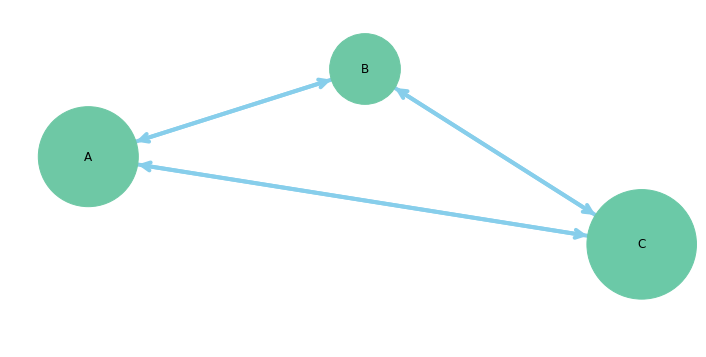

In [11]:
plt.figure(figsize=(12,6))

pos = {0:(1,1), 1: (2,1.2), 2: (3, 0.8)}
labels = {nd: dgsir.node[nd]['sitio'] for nd in dgsir.nodes}
color_map = [dgsir.node[nd]['cor_vertice'] for nd in dgsir.nodes]

size_scale = 50
node_sizes = [size_scale*int(dgsir.node[nd]['populacao']) for nd in dgsir.nodes]

nx.draw_networkx_nodes(dgsir, pos, node_size=node_sizes, with_labels=True, node_shape='o', node_color=color_map)
nx.draw_networkx_labels(dgsir, pos, labels=labels, fontsize=12)
nx.draw_networkx_edges(dgsir, pos, node_size=node_sizes, arrowstyle='->', arrowsize=20, 
                       edge_color='skyblue', width=4)
plt.axis('off')
plt.show()

#### Função taxa de variação

In [12]:
def taxa_de_variacao(X, t, A, gamma):
    S = X[:3]
    I = X[3:]
    AI = np.matmul(A, I)
    diagAIS = AI*S
    dSdt = - diagAIS
    dIdt = diagAIS - gamma*I
    dXdt = np.hstack([dSdt,dIdt])
    return dXdt

#### Resolvendo o sistema

In [13]:
t = np.linspace(0, 100, 101)
X = odeint(taxa_de_variacao, X0, t, args=(A, gamma))

In [14]:
S = X[:,:3]
I = X[:,3:]
R = N0*np.ones_like(S) - S - I

### Gráficos das soluções

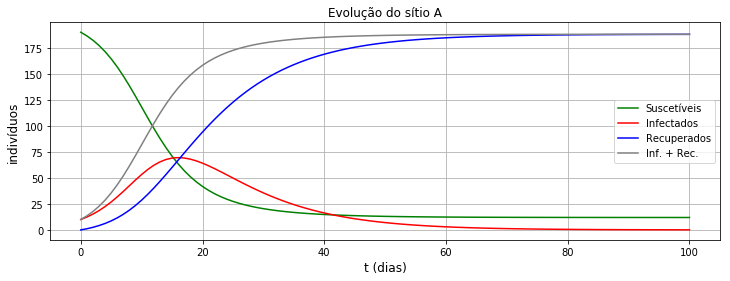

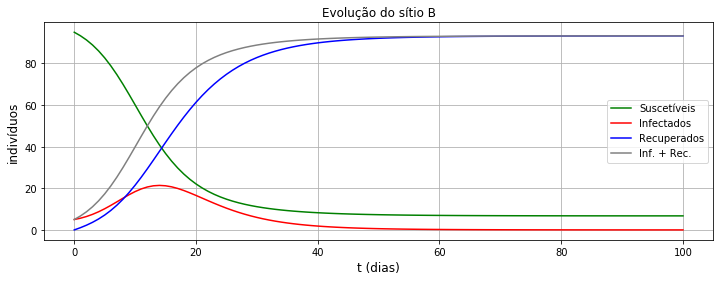

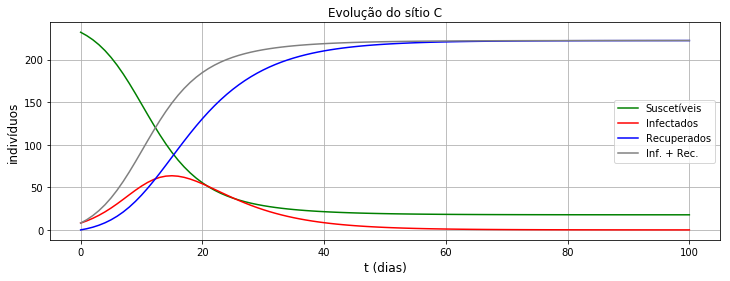

In [15]:
for s in range(num_sitios):
    plt.figure(figsize=(12,4))
    plt.plot(t, S[:,s], 'g', label='Suscetíveis')
    plt.plot(t, I[:,s], 'r', label='Infectados')
    plt.plot(t, R[:,s], 'b', label='Recuperados')
    plt.plot(t, I[:,s] + R[:,s], 'gray', label='Inf. + Rec.')
    plt.legend(loc='best')
    plt.xlabel('t (dias)', fontsize=12)
    plt.ylabel('indivíduos', fontsize=12)
    plt.title(f'Evolução do sítio {sitios[s]}')
    plt.grid()
    plt.show()

### Atualiza dados visuais da rede

In [18]:
nx.set_node_attributes(dgsir, {nd: {'suscetiveis': S[18,nd],
                                    'infectados': I[18,nd],
                                    'recuperados': R[18,nd],
                                   } 
                                for nd in dgsir.nodes
                               }
                      )

nx.set_node_attributes(dgsir, {nd: {'cor_vertice': cor_vertice(dgsir, nd, estagios, cores_estagios)} 
                            for nd in dgsir.nodes
                           }
                      )

### Visualização da rede

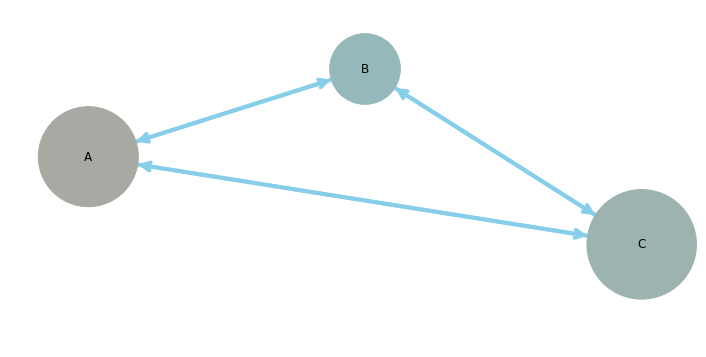

In [19]:
plt.figure(figsize=(12,6))

pos = {0:(1,1), 1: (2,1.2), 2: (3, 0.8)}
labels = {nd: dgsir.node[nd]['sitio'] for nd in dgsir.nodes}
color_map = [dgsir.node[nd]['cor_vertice'] for nd in dgsir.nodes]

size_scale = 50
node_sizes = [size_scale*int(dgsir.node[nd]['populacao']) for nd in dgsir.nodes]

nx.draw_networkx_nodes(dgsir, pos, node_size=node_sizes, with_labels=True, node_shape='o', node_color=color_map)
nx.draw_networkx_labels(dgsir, pos, labels=labels, fontsize=12)
nx.draw_networkx_edges(dgsir, pos, node_size=node_sizes, arrowstyle='->', arrowsize=20, 
                       edge_color='skyblue', width=4)
plt.axis('off')
plt.savefig(path_files_epidemiologia('rede_sitios.png'))
plt.show()

## Dengue no Rio de Janeiro

Dados dos casos de dengue registrados no Rio de Janeiro, distribuídos por semana e bairro, podem ser acessados pela página [Rio Prefeitura - Dengue](http://www.rio.rj.gov.br/web/sms/dengue) (ou diretamente na página [Dengue: dados epidemiológicos](http://www.rio.rj.gov.br/web/sms/exibeconteudo?id=2815389)).

---

### Apresentação em slides

Para visualizar na forma de slides, abrir um "terminal" *bash* e usar a linha de comando
```bash
jupyter nbconvert 13.00-Projeto3.ipynb --to slides --post serve
```

Se quiser adicionar a possibilidade de rolar a página, caso algum *slide* seja muito longo, incluir a opção
```bash
--SlidesExporter.reveal_scroll=True
```
Ou executar diretamente o código na célula a seguir.

In [20]:
!jupyter nbconvert 13.00-Aula13.ipynb --to slides

[NbConvertApp] Converting notebook 13.00-Aula13.ipynb to slides
[NbConvertApp] Writing 523678 bytes to 13.00-Aula13.slides.html


<!--NAVIGATOR-->

---
[<- Projeto 3: Controle de epidemia via vacinação](12.05-Projeto3.ipynb) | [Página Inicial](00-Sumario.ipynb) 

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/13.00-Aula13.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/13.00-Aula13.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/13.00-Aula13.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;